# 라이브러리 불러오기

In [32]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from scipy.spatial import KDTree
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.neighbors import BallTree
from haversine import haversine, Unit
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')


# 1. 데이터셋 소개 및 기본 분석

In [33]:
interest_df = pd.read_csv('data/interestRate.csv')
park_df = pd.read_csv('data/parkInfo.csv')
school_df = pd.read_csv('data/schoolinfo.csv')
subway_df = pd.read_csv('data/subwayInfo.csv')
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

## 데이터 형식 확인

In [34]:
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   area_m2              float64
 2   contract_year_month  int64  
 3   contract_day         int64  
 4   contract_type        int64  
 5   floor                int64  
 6   built_year           int64  
 7   latitude             float64
 8   longitude            float64
 9   age                  int64  
 10  deposit              float64
dtypes: float64(4), int64(7)
memory usage: 151.2 MB
None


## 결측치 값 확인

In [35]:
print(train_df.isnull().sum())

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
dtype: int64


In [36]:
print(interest_df.isna().sum())
print(park_df.isna().sum())
print(school_df.isna().sum())
print(subway_df.isna().sum())

year_month       0
interest_rate    0
dtype: int64
latitude     0
longitude    0
area         0
dtype: int64
schoolLevel    0
latitude       0
longitude      0
dtype: int64
latitude     0
longitude    0
dtype: int64


## 데이터 분포 확인

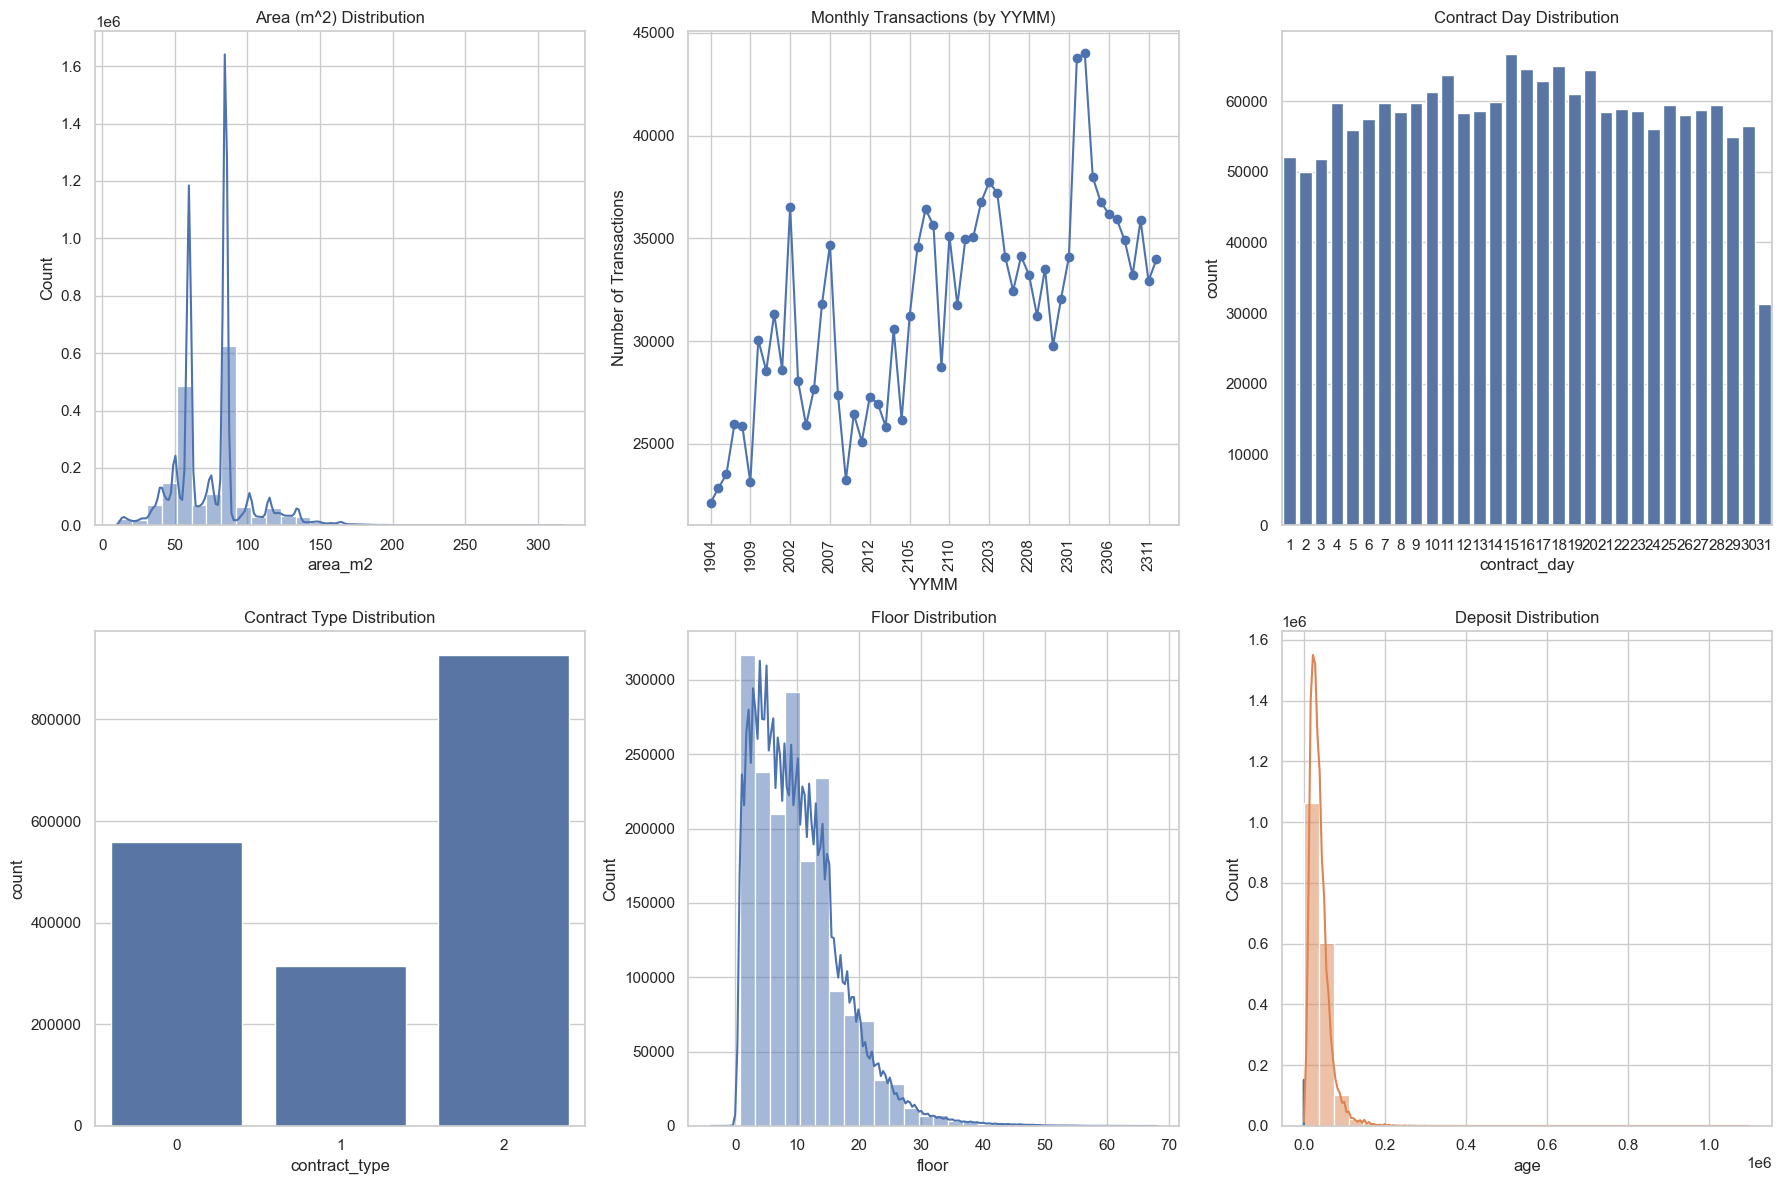

In [37]:

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 그래프를 여러 개 배치할 수 있는 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# 각 변수에 대해 분포 그리기
sns.histplot(train_df['area_m2'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Area (m^2) Distribution')

# contract_year_month를 "YYMM" 형식으로 변환
train_df['contract_year_month'] = train_df['contract_year_month'].astype(str)
train_df['YYMM'] = train_df['contract_year_month'].apply(lambda x: x[2:])

# 월별로 그룹화하고 거래량 계산
monthly_transactions = train_df.groupby('YYMM').size()

# 선그래프 그리기
axes[0, 1].plot(monthly_transactions.index, monthly_transactions.values, marker='o', linestyle='-')
axes[0, 1].set_title('Monthly Transactions (by YYMM)')
axes[0, 1].set_xlabel('YYMM')
axes[0, 1].set_ylabel('Number of Transactions')

# x축 레이블을 간격에 맞춰 표시 (간격을 조정하여 레이블을 줄임)
step = max(1, len(monthly_transactions) // 10)  # 10개의 레이블만 표시
axes[0, 1].set_xticks(axes[0, 1].get_xticks()[::step])
axes[0, 1].tick_params(axis='x', rotation=90)

sns.countplot(x=train_df['contract_day'], ax=axes[0, 2])
axes[0, 2].set_title('Contract Day Distribution')

sns.countplot(x=train_df['contract_type'], ax=axes[1, 0])
axes[1, 0].set_title('Contract Type Distribution')

sns.histplot(train_df['floor'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Floor Distribution')

sns.histplot(train_df['age'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Building Age Distribution')

# deposit 분포 추가
sns.histplot(train_df['deposit'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Deposit Distribution')

# 레이아웃 조정
plt.tight_layout()
plt.show()



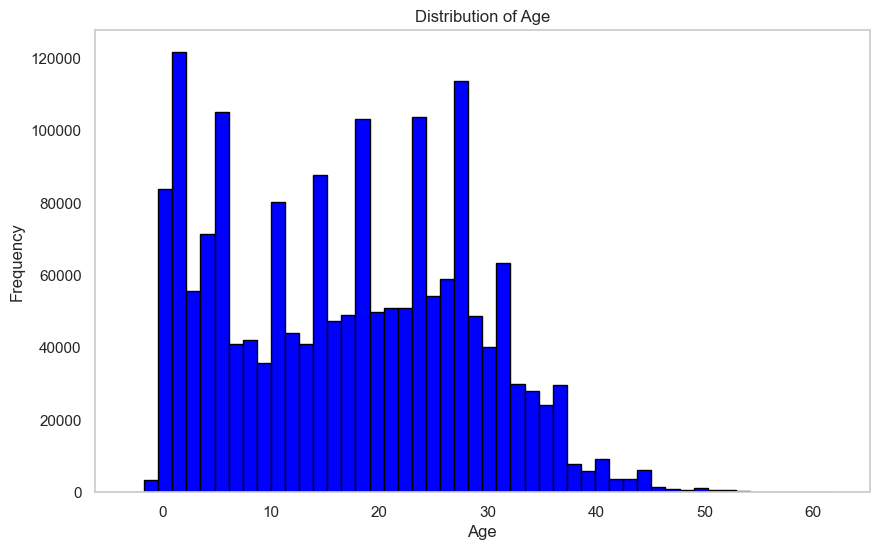

In [38]:
# Age graph
plt.figure(figsize=(10, 6))
train_df['age'].hist(bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


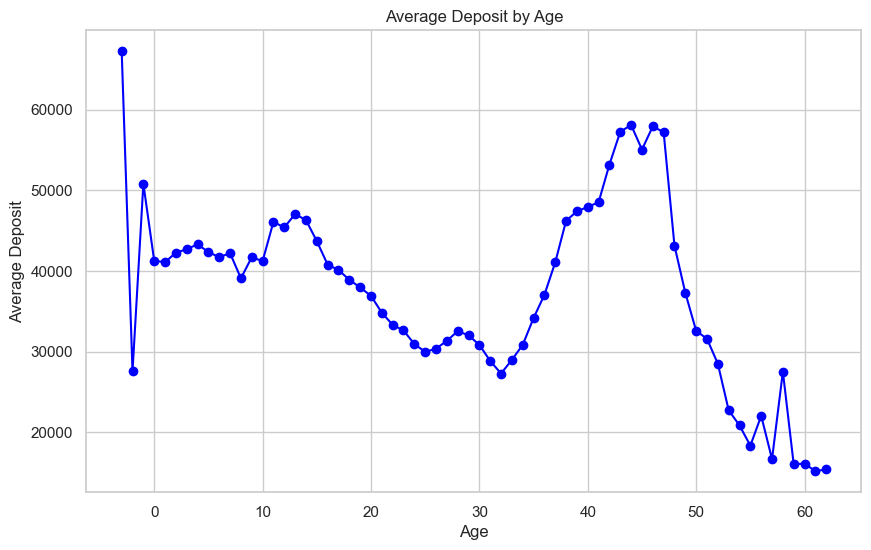

In [39]:
# 'age'를 기준으로 그룹화하고 'deposit'의 평균을 계산
age_deposit_avg = train_df.groupby('age')['deposit'].mean().reset_index()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(age_deposit_avg['age'], age_deposit_avg['deposit'], marker='o', color='blue')
plt.title('Average Deposit by Age')
plt.xlabel('Age')
plt.ylabel('Average Deposit')
plt.grid(True)
plt.show()

In [40]:
train_df['deposit_per_m2'] = train_df['deposit'] / train_df['area_m2']


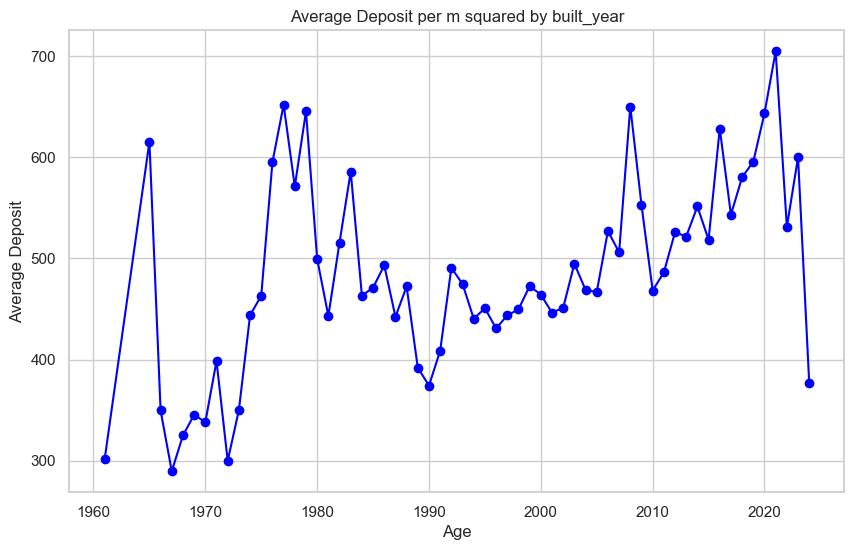

In [41]:
# 'built_year'를 기준으로 그룹화하고 'deposit_per_m2'의 평균을 계산
age_deposit_avg = train_df.groupby('built_year')['deposit_per_m2'].mean().reset_index()

# # 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(age_deposit_avg['built_year'], age_deposit_avg['deposit_per_m2'], marker='o', color='blue')
plt.title('Average Deposit per m squared by built_year')
plt.xlabel('Age')
plt.ylabel('Average Deposit')
plt.grid(True)
plt.show()

## 이상치 확인

In [42]:
train_df['floor'].value_counts().sort_index()


floor
-4      1
-3      1
-2      8
-1     57
 0      3
       ..
 64     1
 65     2
 66     2
 67     1
 68     4
Name: count, Length: 73, dtype: int64

In [43]:
# 층이 0보다 작은 데이터 필터링
train_df[train_df['floor'] <= 0].shape

(70, 13)

In [44]:
# 층이 0 이하인 데이터 필터링
low_floor_data = train_df[train_df['floor'] <= 0]

# 같은 위도, 경도, 면적을 가진 다른 거래와 비교하기 위해 데이터 그룹화
# floor가 0 이하인 거래의 고유한 위도, 경도, 면적 추출
unique_properties = low_floor_data[['latitude', 'longitude', 'area_m2']].drop_duplicates()

# 결과를 저장할 리스트
comparison_results = []

# 고유한 위도, 경도, 면적을 가진 다른 거래와 비교
for index, row in unique_properties.iterrows():
    # 같은 위도, 경도, 면적을 가진 모든 거래 추출
    similar_transactions = train_df[
        (train_df['latitude'] == row['latitude']) &
        (train_df['longitude'] == row['longitude']) &
        (train_df['area_m2'] == row['area_m2'])
    ]

    # 층이 0 이하인 거래와 층이 0보다 큰 거래의 보증금 차이를 계산
    low_floor_deposit = similar_transactions[similar_transactions['floor'] <= 0]['deposit'].mean()
    other_floor_deposit = similar_transactions[similar_transactions['floor'] > 0]['deposit'].mean()

    # 차이를 계산하여 저장
    deposit_difference = low_floor_deposit - other_floor_deposit
    comparison_results.append({
        'latitude': row['latitude'],
        'longitude': row['longitude'],
        'area_m2': row['area_m2'],
        'low_floor_deposit': low_floor_deposit,
        'other_floor_deposit': other_floor_deposit,
        'deposit_difference': deposit_difference
    })

# 비교 결과를 데이터프레임으로 변환
comparison_df = pd.DataFrame(comparison_results)

# 결과 출력
comparison_df

latitude   longitude  area_m2  low_floor_deposit  other_floor_deposit  \
0   37.374628  127.114846   84.900            64000.0         69182.901786   
1   37.593130  127.142876   59.310            20000.0         24000.000000   
2   37.295999  127.153425   84.960            43000.0                  NaN   
3   37.551136  126.974959   20.960             7500.0                  NaN   
4   37.523559  126.959247   58.580            13000.0         22200.000000   
5   37.637105  126.928169  134.710            69500.0                  NaN   
6   37.563496  126.954801   97.030            40000.0         36916.666667   
7   37.572963  126.928727   83.490            18000.0                  NaN   
8   37.483197  126.844729   84.780            44000.0                  NaN   
9   37.486550  126.840182   84.950            55000.0                  NaN   
10  37.476188  126.904588   95.185            16000.0                  NaN   
11  37.487864  127.043825  213.940           350000.0                  NaN   
12  37.613021  126.933779  125.380            71000.0         73000.000000   
13  37.613021  126.933779   95.490            67000.0                  NaN   
14  37.483197  126.844729   84.950            53500.0         49500.000000   
15  37.553514  126.944932   75.060            45000.0                  NaN   
16  37.607004  126.957327  140.040            47500.0                  NaN   
17  37.547574  127.012878   76.660            81750.0                  NaN   
18  37.590628  127.003123  198.810           100000.0                  NaN   
19  37.637105  126.928169  134.460            62000.0                  NaN   
20  37.637105  126.928169  101.970            49725.0                  NaN   
21  37.556246  126.982537   27.100            12500.0                  NaN   
22  37.610887  127.002392   51.170             2800.0                  NaN   
23  37.537751  126.861309  102.370            47500.0         31000.000000   
24  37.590013  126.948494   67.240            63000.0                  NaN   
25  37.523559  126.959247   65.550            30000.0         19906.250000   
26  37.550755  127.006461   59.900            18000.0                  NaN   
27  37.550872  127.005462   53.880            13650.0         22000.000000   
28  37.549443  126.975527   73.600            26700.0                  NaN   
29  37.549443  126.975527   82.770            31000.0                  NaN   
30  37.578220  127.021672   60.000            26000.0                  NaN   
31  37.637105  126.928169  134.790            80000.0                  NaN   
32  37.551007  127.005238   55.730            22000.0         23000.000000   
33  37.507879  126.916674   84.990            70000.0                  NaN   
34  37.550872  127.005462   38.930            13000.0         13000.000000   
35  37.523559  126.959247   66.080            17000.0         20117.307692   
36  37.576722  127.019720   59.560            40000.0                  NaN   
37  37.542460  126.964273  111.920            64000.0                  NaN   
38  37.573225  126.929588   33.060             5250.0                  NaN   
39  37.541541  126.966886  130.930            65000.0         66750.000000   
40  37.551121  127.005577   29.400             6500.0          9000.000000   
41  37.550705  127.005566   59.950            12000.0         16000.000000   
42  37.550376  127.005442   59.990            13000.0         15000.000000   
43  37.534703  127.009230   28.300            10000.0                  NaN   
44  37.614333  127.040002   80.550            13000.0                  NaN   
45  37.637105  126.928169  134.510            75000.0                  NaN   

    deposit_difference  
0         -5182.901786  
1         -4000.000000  
2                  NaN  
3                  NaN  
4         -9200.000000  
5                  NaN  
6          3083.333333  
7                  NaN  
8                  NaN  
9                  NaN  
10                 NaN  
11                 NaN  
12        -20

In [45]:
# latitude longitude 기준으로 아파트 거래량 계산
apartment_frequency = train_df.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')
# 빈도 기준 정렬
apartment_frequency_sorted = apartment_frequency.sort_values(by='frequency', ascending=False)
apartment_frequency_sorted.head(10)

latitude   longitude  frequency
16883  37.654629  127.340430       5108
8470   37.497618  127.107260       3781
10261  37.521233  127.108648       3206
8481   37.497741  127.065070       2832
9698   37.513305  127.081596       2705
451    37.113681  126.910849       2581
17543  37.694017  126.762857       2520
9703   37.513393  127.086817       2425
9836   37.515759  127.093939       2415
13289  37.557573  127.163406       2399

In [46]:
# 최대 빈도 아파트 위,경도
target_latitude = 37.654629
target_longitude = 127.340430

# np.isclose를 사용하여 근사값 비교로 데이터 필터링
specific_apartment_data = train_df[np.isclose(train_df['latitude'], target_latitude) & np.isclose(train_df['longitude'], target_longitude)]

# 해당 아파트 데이터에 대한 통계량 확인
apartment_statistics = specific_apartment_data.describe(include='all')

# 결과 출력
apartment_statistics

index      area_m2 contract_year_month  contract_day  \
count     5108.000000  5108.000000                5108   5108.000000   
unique            NaN          NaN                  57           NaN   
top               NaN          NaN              201911           NaN   
freq              NaN          NaN                 171           NaN   
mean    334340.472788    83.156061                 NaN     15.702819   
std     261317.726323    23.328678                 NaN      8.505551   
min       4097.000000    59.963200                 NaN      1.000000   
25%     167673.750000    59.963200                 NaN      8.000000   
50%     337276.500000    84.972700                 NaN     16.000000   
75%     553667.250000    84.994700                 NaN     23.000000   
max     778941.000000   148.004200                 NaN     31.000000   

        contract_type        floor  built_year     latitude     longitude  \
count     5108.000000  5108.000000      5108.0  5108.000000  5.108000e+03   
unique            NaN          NaN         NaN          NaN           NaN   
top               NaN          NaN         NaN          NaN           NaN   
freq              NaN          NaN         NaN          NaN           NaN   
mean         1.814409    15.934612      2015.0    37.654629  1.273404e+02   
std          0.529539     8.807563         0.0     0.000000  1.421225e-14   
min          0.000000     1.000000      2015.0    37.654629  1.273404e+02   
25%          2.000000     8.000000      2015.0    37.654629  1.273404e+02   
50%          2.000000    16.000000      2015.0    37.654629  1.273404e+02   
75%          2.000000    23.000000      2015.0    37.654629  1.273404e+02   
max          2.000000    33.000000      2015.0    37.654629  1.273404e+02   

                age       deposit  YYMM  deposit_per_m2  
count   5108.000000   5108.000000  5108     5108.000000  
unique          NaN           NaN    57             NaN  
top             NaN           NaN  1911             NaN  
freq            NaN           NaN   171             NaN  
mean       6.053250  18231.557753   NaN      225.185326  
std        1.360835   3131.262681   NaN       24.214322  
min        4.000000   1450.000000   NaN       24.181498  
25%        5.000000  14964.000000   NaN      223.543350  
50%        6.000000  19000.000000   NaN      224.571954  
75%        7.000000  19000.000000   NaN      241.814980  
max        8.000000  39000.000000   NaN      400.245484

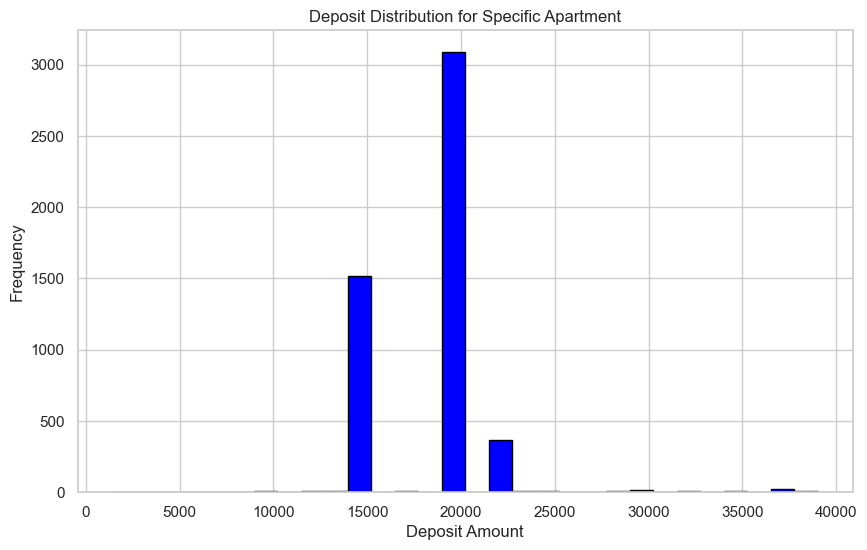

In [47]:
# deposit의 분포를 시각화하기 위해 히스토그램을 생성
plt.figure(figsize=(10, 6))
plt.hist(specific_apartment_data['deposit'], bins=30, color='blue', edgecolor='black')
plt.title('Deposit Distribution for Specific Apartment')
plt.xlabel('Deposit Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

최대 빈도 남양주에 위치한 부영 아파트의 거래는 19000에 약 50% 가 차지하고 실제 뉴스 검색 결과 장기전세 정책으로 전세 계약 기록이 많이 차지한다. 장기전세 는 주변 지역 시세보다 80% 이하로 거래되므로 파악하면 도움이 될 것이다.

In [48]:
train_df['age'].value_counts().sort_index()



age
-3         4
-2        28
-1      3419
 0     83870
 1     40128
       ...  
 58        2
 59        2
 60        5
 61        5
 62        5
Name: count, Length: 66, dtype: int64

- 확인 결과 age가 - 인 데이터는 정상적. 입주 기간이 늦어지거나 공공 민간임대인 경우도 있고 건축 연도가 실제로 계약 시작일로부터 age만큼 후랑 맞음

In [49]:
train_df['built_year'].value_counts().sort_index()


built_year
1961       17
1965       15
1966       11
1967       17
1968      116
        ...  
2020    51176
2021    43894
2022    31119
2023    16483
2024       97
Name: count, Length: 61, dtype: int64

In [50]:
train_df['contract_year_month'].value_counts().sort_index()


contract_year_month
201904    22136
201905    22860
201906    23533
201907    25951
201908    25862
201909    23136
201910    30067
201911    28558
201912    31342
202001    28608
202002    36542
202003    28046
202004    25913
202005    27692
202006    31814
202007    34699
202008    27396
202009    23256
202010    26456
202011    25121
202012    27294
202101    26967
202102    25850
202103    30586
202104    26174
202105    31216
202106    34599
202107    36424
202108    35631
202109    28741
202110    35105
202111    31759
202112    34962
202201    35076
202202    36793
202203    37736
202204    37214
202205    34113
202206    32452
202207    34131
202208    33213
202209    31235
202210    33522
202211    29759
202212    32035
202301    34090
202302    43754
202303    44002
202304    37972
202305    36769
202306    36200
202307    35947
202308    34908
202309    33218
202310    35878
202311    32931
202312    33984
Name: count, dtype: int64

- 건물의 나이가 음수값을 가지는 것들이 존재한다
- 2023년까지의 데이터를 사용함에도 건설년도가 2024년인 아파트가 있다.
- 거래연도에는 이상치가 없었다.

# 2. 주요 변수별 심화 분석 및 타겟값과의 관계 확인

## 2.1 연도, 월별 전세가 변화 분석

In [51]:
train_df['year'] = train_df['contract_year_month'].astype(str).str[:4].astype(int)
train_df['month'] = train_df['contract_year_month'].astype(str).str[4:6].astype(int)

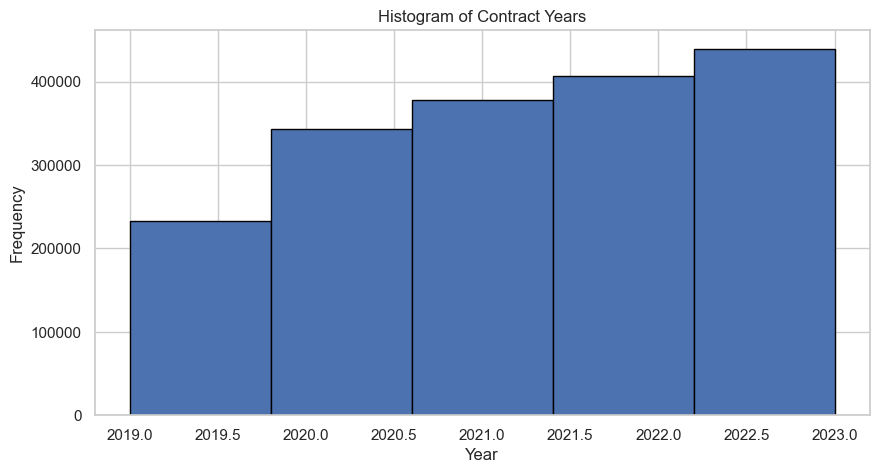

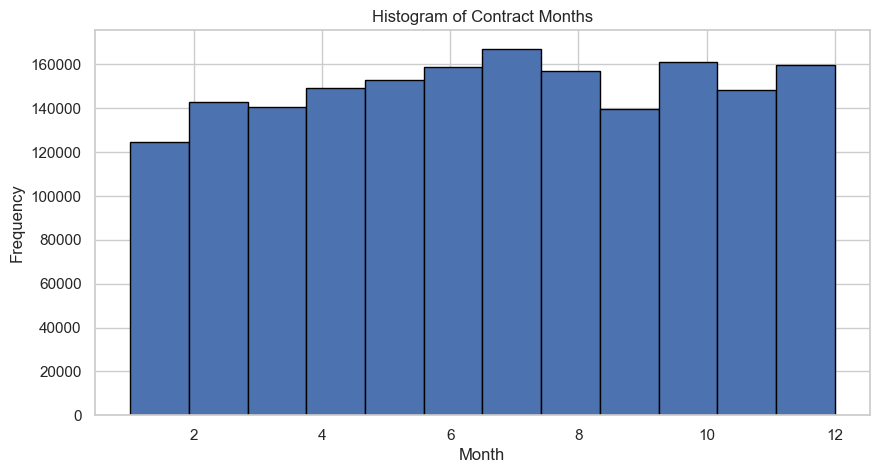

In [52]:
# 연도별 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(train_df['year'], bins=len(train_df['year'].unique()), edgecolor='black')
plt.title('Histogram of Contract Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 월별 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(train_df['month'], bins=12, edgecolor='black')
plt.title('Histogram of Contract Months')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- 전반적으로 좌측에 분포하는 것을 알 수 있다.
- 계약 연월과 계약일은 고른 분포를 나타내고 있다.
- 계약 타입에서는 모름 > 신규 > 갱신의 순서를 보이고 있다.

## 2.2 변수별 타겟값 관계 분석

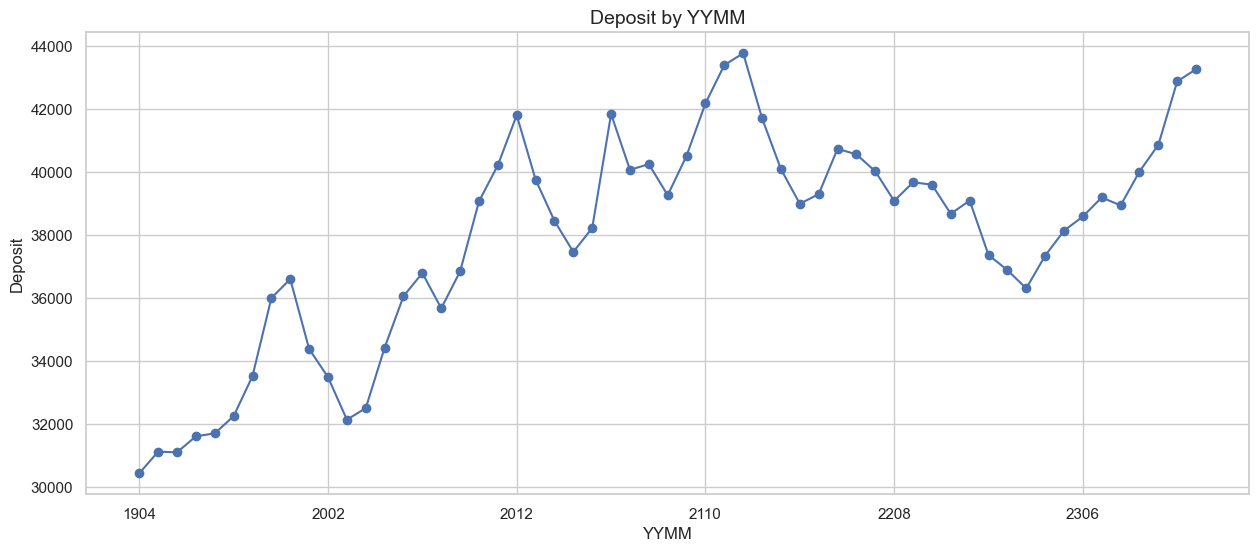

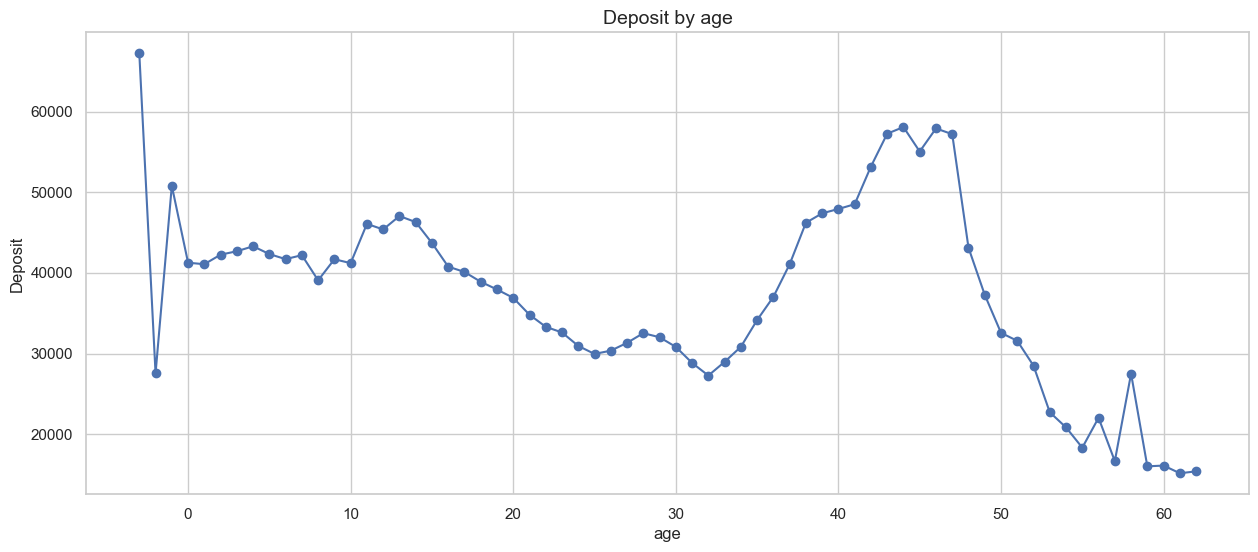

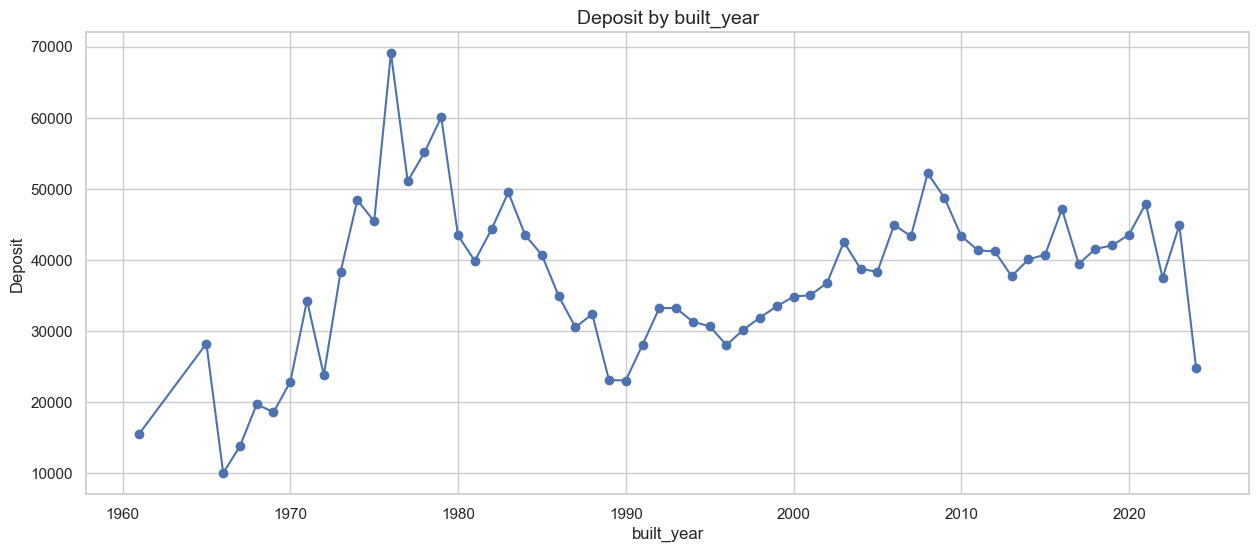

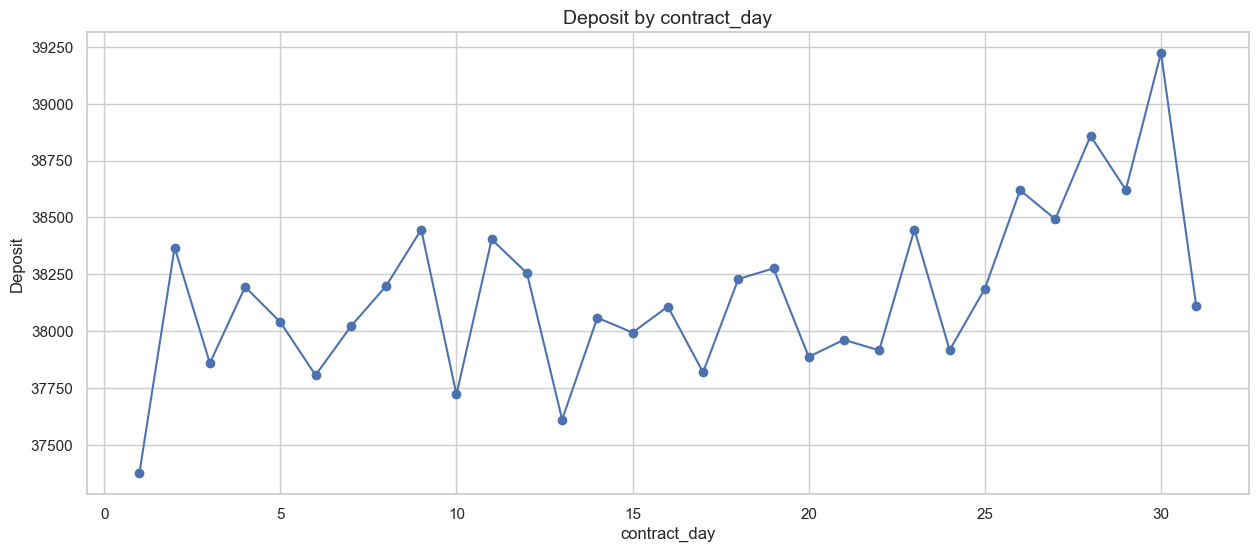

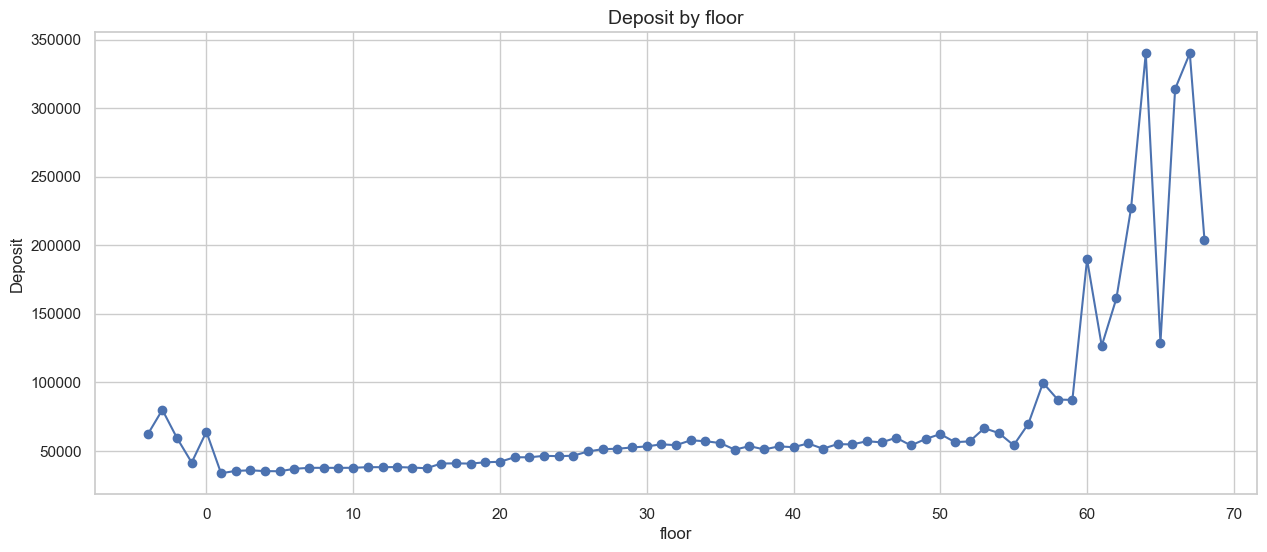

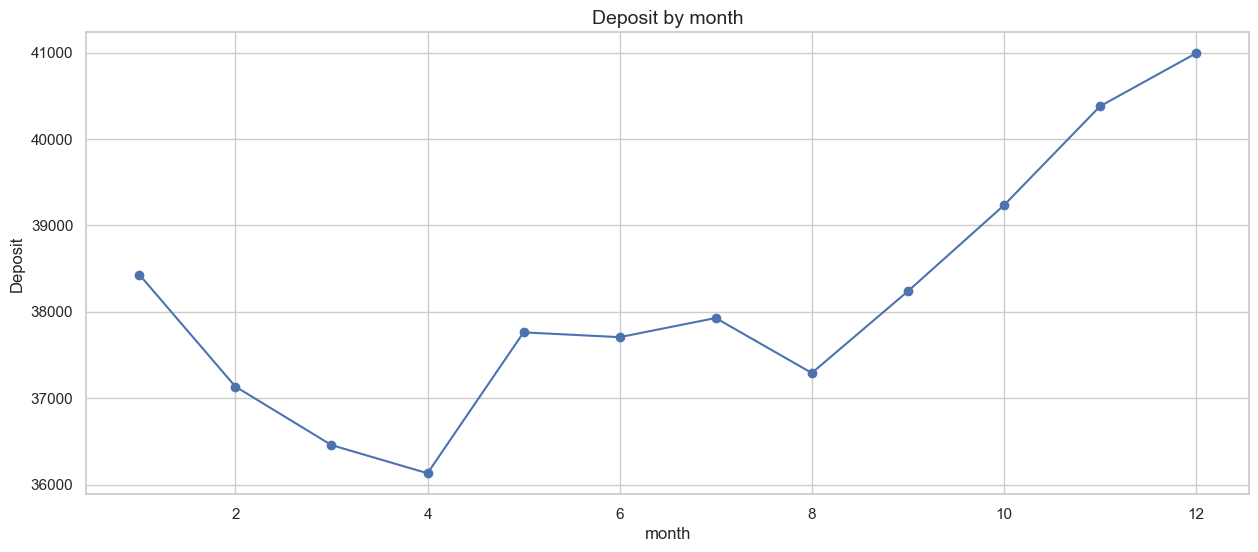

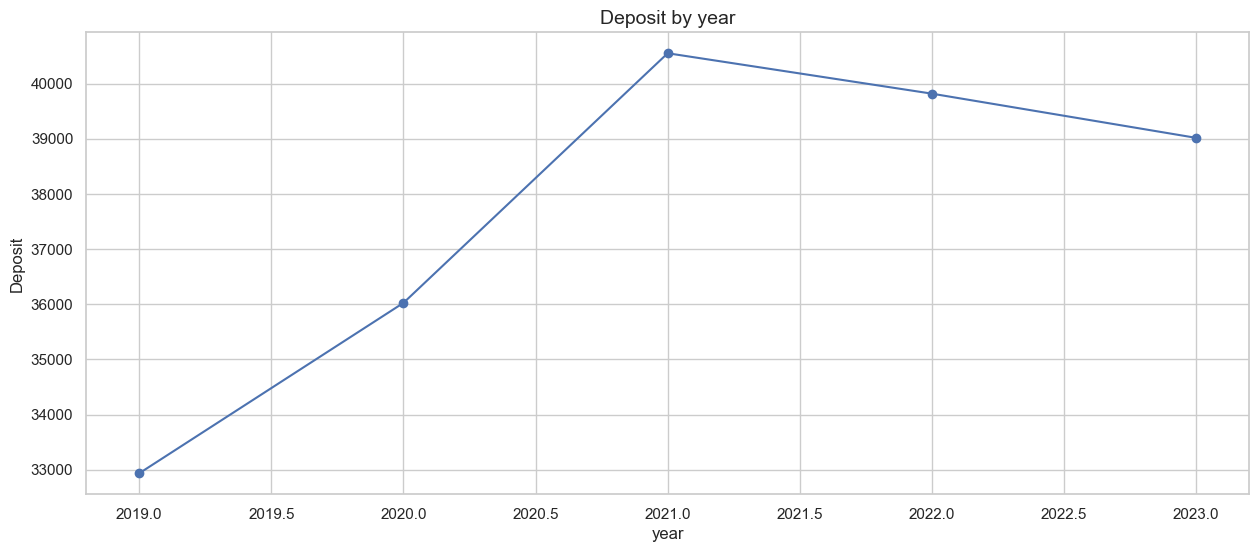

In [53]:
def plot_deposit_by_selected_variables(df, selected_variables):
    for variable in selected_variables:
        plt.figure(figsize=(15, 6))
        df.groupby(variable)['deposit'].mean().plot(marker='o')
        plt.title(f'Deposit by {variable}', fontsize=14)
        plt.xlabel(variable, fontsize=12)
        plt.ylabel('Deposit', fontsize=12)
        plt.grid(True)
        plt.show()

# 선택된 변수들
selected_variables = ['YYMM', 'age', 'built_year', 'contract_day', 'floor', 'month', 'year']

# 함수 호출
plot_deposit_by_selected_variables(train_df, selected_variables)

- 2019년부터 21년까지 전세가의 평균이 오르다가 21년부터 23년까지 떨어진다.
- 8월부터 전세가가 증가 추세이다.
- 57층 정도부터 전세가가 급증한다.
- 월말에 가까워지면 전세가가 오른다.
- 아파트의 연식이 40년 이상이 되면 잠깐 가격이 오른다.

# 3. 지역 및 인프라 관련 분석

## 3.1 주변 아파트의 전세가 영향

### 3.1.1 동일 금리, 위치, 면적 조건에서의 아파트 가격 차이 분석

In [54]:
train_data = train_df.copy()
cols=['area_m2','contract_year_month','floor','latitude','longitude','age']
train_data['combo'] = train_data[cols].astype(str).agg('_'.join,axis=1)
train_data['combo'].astype('category')
train_data.drop(columns=cols,inplace=True)

### 중복값 제거
train_data = train_data.drop_duplicates(subset=['combo','deposit'])


면적, 계약일, 층수, 위경도, 계약 유형이 같은 경우에 가격이 다른 경우를 확인<br>
이러한 데이터의 개수와 양상을 파악하기

In [55]:
combo_df = pd.DataFrame(train_data.groupby('combo').agg('count')['deposit'])
combo_df = combo_df[combo_df['deposit']>=2]
combo_df

deposit
combo                                               
10.92_202107_7_37.5453611_126.8463672_9            2
10.92_202110_4_37.5453611_126.8463672_9            2
100.03_202112_1_37.3060249_126.8511509_22          2
100.0633_201912_12_36.9975316_127.1426227_9        2
100.088_202007_3_37.3292668_127.0744468_15         2
...                                              ...
99.98_202209_1_37.741006_127.0976601_23            2
99.9941_202212_25_37.4108669_126.9890872_0         2
99.9_201912_2_37.3265323_127.0884968_25            2
99.9_202209_9_37.2686702_127.0203512_0             2
99.9_202304_9_37.3265323_127.0884968_29            2

[93189 rows x 1 columns]

In [56]:
cost_df = train_data.groupby('combo').agg(
    deposit_count=('deposit', 'count'),
    min_price=('deposit', 'min'),
    max_price=('deposit', 'max'),
)

# deposit의 개수가 2 이상인 데이터만 필터링
cost_df = cost_df[cost_df['deposit_count'] >= 2]
cost_df = cost_df.assign(mm = lambda x : cost_df['max_price'] - cost_df['min_price'])

cost_df


deposit_count  min_price  \
combo                                                                   
10.92_202107_7_37.5453611_126.8463672_9                  2     9500.0   
10.92_202110_4_37.5453611_126.8463672_9                  2     8400.0   
100.03_202112_1_37.3060249_126.8511509_22                2    30500.0   
100.0633_201912_12_36.9975316_127.1426227_9              2    17000.0   
100.088_202007_3_37.3292668_127.0744468_15               2    42000.0   
...                                                    ...        ...   
99.98_202209_1_37.741006_127.0976601_23                  2    27000.0   
99.9941_202212_25_37.4108669_126.9890872_0               2    50000.0   
99.9_201912_2_37.3265323_127.0884968_25                  2    35000.0   
99.9_202209_9_37.2686702_127.0203512_0                   2    45000.0   
99.9_202304_9_37.3265323_127.0884968_29                  2    39000.0   

                                             max_price       mm  
combo                                                            
10.92_202107_7_37.5453611_126.8463672_9        10000.0    500.0  
10.92_202110_4_37.5453611_126.8463672_9         9500.0   1100.0  
100.03_202112_1_37.3060249_126.8511509_22      41000.0  10500.0  
100.0633_201912_12_36.9975316_127.1426227_9    18000.0   1000.0  
100.088_202007_3_37.3292668_127.0744468_15     43000.0   1000.0  
...                                                ...      ...  
99.98_202209_1_37.741006_127.0976601_23        28000.0   1000.0  
99.9941_202212_25_37.4108669_126.9890872_0     58000.0   8000.0  
99.9_201912_2_37.3265323_127.0884968_25        36000.0   1000.0  
99.9_202209_9_37.2686702_127.0203512_0         47000.0   2000.0  
99.9_202304_9_37.3265323_127.0884968_29        42000.0   3000.0  

[93189 rows x 4 columns]

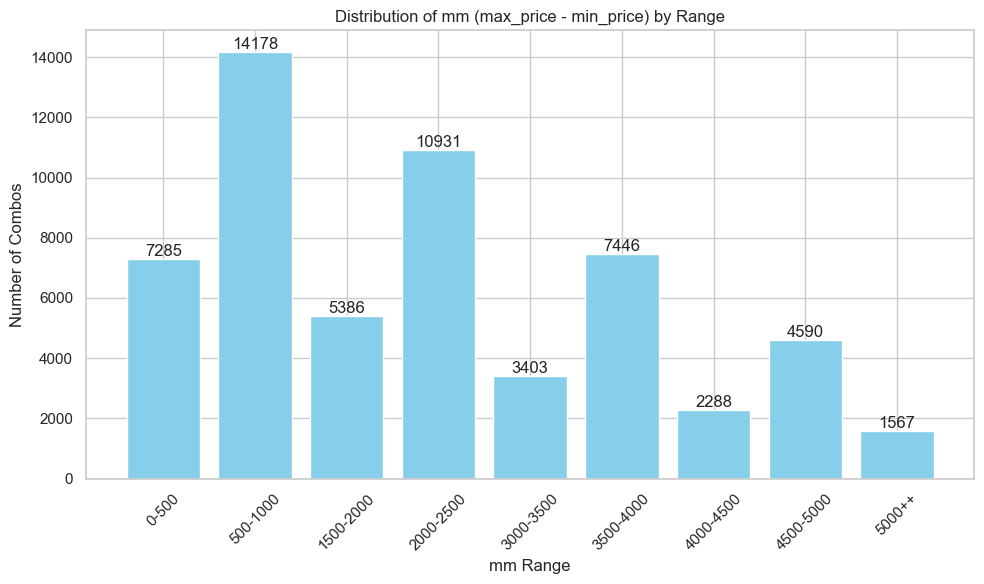

In [57]:

# Step 2: mm 값을 구간으로 나누기 (bins는 원하는 구간 수로 조정 가능)
bins = [i for i in range(0,5000,500)]  # 예시 구간 (수정 가능)
labels = ['0-500', '500-1000', '1500-2000', '2000-2500', '3000-3500', '3500-4000', '4000-4500','4500-5000','5000++']

cost_df['mm_bin'] = pd.cut(cost_df['mm'], bins=bins, labels=labels)

# Step 3: 각 구간별 개수 세기
mm_bin_counts = cost_df['mm_bin'].value_counts().sort_index()

# Step 4: 시각화 (막대그래프)
plt.figure(figsize=(10, 6))
bars = plt.bar(mm_bin_counts.index, mm_bin_counts.values, color='skyblue')

for bar in bars:
    yval = bar.get_height()  # 막대의 높이 (개수)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')  # 텍스트를 막대 위에 표시

plt.title('Distribution of mm (max_price - min_price) by Range')
plt.xlabel('mm Range')
plt.ylabel('Number of Combos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.1.2 같은 아파트 내 세대 면적에 따른 가격 상승 동조 현상 분석

In [58]:
house_df = train_df.copy()
house_df['contract_datetime'] = house_df['contract_year_month'].astype(str) + house_df['contract_day'].astype(str)
house_df['contract_datetime'] = pd.to_datetime(house_df['contract_datetime'], format='%Y%m%d')
house_df = house_df.drop(columns=['contract_year_month', 'contract_day'])
house_df.sort_values(by=['latitude', 'longitude'], inplace=True)
house_df.drop_duplicates(inplace=True)

In [59]:
# 위도, 경도를 기준으로 아파트마다 고유한 id를 생성합니다.
loc = house_df[['latitude', 'longitude']].drop_duplicates().values.tolist()
loc_to_id = {tuple(loc): id for id, loc in enumerate(loc)}
loc_tuples = (house_df['latitude'].values, house_df['longitude'].values)
house_df['loc_id'] = [loc_to_id[tuple(loc)] for loc in zip(*loc_tuples)]

# 위도, 경도 및 area_m2를 기준으로 단지마다 고유한 id를 생성합니다.
loc_area = house_df[['latitude', 'longitude', 'area_m2']].drop_duplicates().values.tolist()
loc_area_to_id = {tuple(loc_area): id for id, loc_area in enumerate(loc_area)}
loc_area_tuples = (house_df['latitude'].values, house_df['longitude'].values, house_df['area_m2'].values)
house_df['loc_area_id'] = [loc_area_to_id[tuple(loc_area)] for loc_area in zip(*loc_area_tuples)]

In [60]:
# 단지마다 전세가 그래프를 생성합니다.
house_df.sort_values(by=['loc_area_id', 'contract_datetime'], inplace=True)
grouped_house_df = house_df.groupby('loc_area_id')

full_date_range = pd.date_range(start='2019-01-01', end='2023-01-01', freq='1D')
area_id_to_deposit_series = {
    loc_area_id: deposit_series.set_index('contract_datetime')['deposit']
                           .resample('1d').mean()
                           .reindex(full_date_range)
                           .interpolate(method='linear', limit_area='inside')
                            .rolling(window=90, min_periods=1).mean()
    for loc_area_id, deposit_series in grouped_house_df
}


In [61]:
id_to_area_ids = {}
for loc_id, group in house_df.groupby('loc_id'):
    id_to_area_ids[loc_id] = group['loc_area_id'].unique()

n_correct_plus = 0
n_correct_minus = 0
n_wrong = 0
for loc_id, area_ids in id_to_area_ids.items():

    # 20년부터 22년까지, 반년 간격으로 측정합니다.
    start_datetime = pd.Timestamp('2020-01-01')
    end_datetime = pd.Timestamp('2022-01-01')
    cur_datetime = start_datetime
    delta = pd.Timedelta(days=180)

    while cur_datetime < end_datetime + delta:
        next_datetime = cur_datetime + delta

        # 같은 아파트 내 집들의 변화를 계산합니다.
        deposit_diffs = []
        for area_id in area_ids:
            deposit_series = area_id_to_deposit_series[area_id]
            cur_deposit = deposit_series.loc[cur_datetime]
            next_deposit = deposit_series.loc[next_datetime]
            deposit_diff = next_deposit - cur_deposit
            if deposit_diff == 0 or np.isnan(deposit_diff):
                continue
            deposit_diffs.append(deposit_diff)

        # 두 집의 변화 추세가 같은지 다른지를 셉니다.
        if len(deposit_diffs) >= 2:
            for diff1, diff2 in itertools.combinations(deposit_diffs, 2):
                if np.sign(diff1) == np.sign(diff2) == 1:
                    n_correct_plus += 1
                elif np.sign(diff1) == np.sign(diff2) == -1:
                    n_correct_minus += 1
                else:
                    n_wrong += 1
        cur_datetime = next_datetime

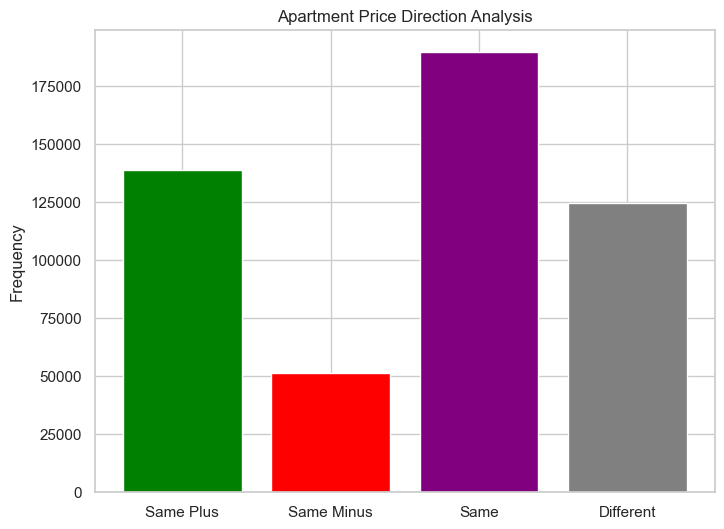

일치율: 0.6034323705306018


In [62]:

# 데이터 준비
categories = ['Same Plus', 'Same Minus', 'Same', 'Different']
values = [n_correct_plus, n_correct_minus, n_correct_plus + n_correct_minus, n_wrong]

# 막대 그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['green', 'red', 'purple', 'grey'])
plt.ylabel('Frequency')
plt.title('Apartment Price Direction Analysis')
plt.show()

print(f'일치율: {(n_correct_plus + n_correct_minus) / (n_wrong + n_correct_plus + n_correct_minus)}')

### 3.1.3 반경 1km 내 아파트 가격 상승이 인근 아파트에 미치는 영향 분석

In [63]:
unique_house_df = house_df.drop_duplicates(subset='loc_id', keep='first')
unique_house_df = unique_house_df.drop(columns=['contract_datetime', 'deposit'])
unique_house_df = unique_house_df.sort_values(by='loc_id')


tree = KDTree(unique_house_df[['latitude', 'longitude']])
half_km_results = tree.query_ball_point(unique_house_df[['latitude', 'longitude']].values, r=0.005)

# 아파트 id를 반경 1km 주변 아파트 id로 매핑시키는 dict를 생성합니다.
id_to_half_km_ids = {}
for i, result in enumerate(half_km_results):
    id = unique_house_df.iloc[i]['loc_id']
    half_km_ids = [unique_house_df.iloc[j]['loc_id'] for j in result]
    id_to_half_km_ids[id] = half_km_ids

In [64]:
id_to_area_ids = {}
for loc_id, group in house_df.groupby('loc_id'):
    id_to_area_ids[loc_id] = group['loc_area_id'].unique()

n_correct_plus = 0
n_correct_minus = 0
n_wrong = 0
for loc_id, half_km_ids in id_to_half_km_ids.items():
    area_ids = id_to_area_ids[loc_id]
    half_km_area_ids = id_to_area_ids[half_km_ids[0]]

    # 20년부터 22년까지, 반년 간격으로 측정합니다.
    start_datetime = pd.Timestamp('2020-01-01')
    end_datetime = pd.Timestamp('2022-01-01')
    cur_datetime = start_datetime
    delta = pd.Timedelta(days=180)

    while cur_datetime < end_datetime + delta:
        next_datetime = cur_datetime + delta

        # 같은 아파트 내 집들의 변화를 계산합니다.
        deposit_diffs = []
        for area_id in area_ids:
            deposit_series = area_id_to_deposit_series[area_id]
            cur_deposit = deposit_series.loc[cur_datetime]
            next_deposit = deposit_series.loc[next_datetime]
            deposit_diff = next_deposit - cur_deposit
            if deposit_diff == 0 or np.isnan(deposit_diff):
                continue
            deposit_diffs.append(deposit_diff)
        deposit_average_diff = np.mean(deposit_diffs)

        # 아파트 반경 1km 내 집들의 변화를 계산합니다.
        half_km_deposit_diffs = []
        for area_id in half_km_area_ids:
            deposit_series = area_id_to_deposit_series[area_id]
            cur_deposit = deposit_series.loc[cur_datetime]
            next_deposit = deposit_series.loc[next_datetime]
            deposit_diff = next_deposit - cur_deposit
            if deposit_diff == 0 or np.isnan(deposit_diff):
                continue
            half_km_deposit_diffs.append(deposit_diff)
        half_km_deposit_average_diff = np.mean(half_km_deposit_diffs)

        # 두 변화 추세가 같은지 다른지를 셉니다.
        if not np.isnan(deposit_average_diff) and not np.isnan(half_km_deposit_average_diff):
            if np.sign(deposit_average_diff) == np.sign(half_km_deposit_average_diff) == 1:
                n_correct_plus += 1
            elif np.sign(deposit_average_diff) == np.sign(half_km_deposit_average_diff) == -1:
                n_correct_minus += 1
            else:
                n_wrong += 1

        cur_datetime = next_datetime

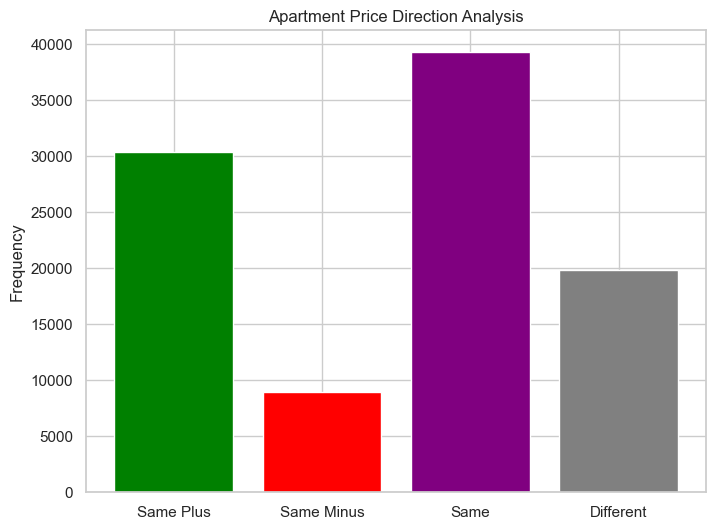

일치율: 0.6648244857949264


In [65]:
# 데이터 준비
categories = ['Same Plus', 'Same Minus', 'Same', 'Different']
values = [n_correct_plus, n_correct_minus, n_correct_plus + n_correct_minus, n_wrong]

# 막대 그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['green', 'red', 'purple', 'grey'])
plt.ylabel('Frequency')
plt.title('Apartment Price Direction Analysis')
plt.show()

print(f'일치율: {(n_correct_plus + n_correct_minus) / (n_wrong + n_correct_plus + n_correct_minus)}')

### 3.1.4 무작위 아파트 간 가격 변동 방향성 비교 분석

In [66]:
id_to_area_ids = {}
for loc_id, group in house_df.groupby('loc_id'):
    id_to_area_ids[loc_id] = group['loc_area_id'].unique()

n_correct_plus = 0
n_correct_minus = 0
n_wrong = 0

# 20년부터 22년까지, 반년 간격으로 측정합니다.
start_datetime = pd.Timestamp('2020-01-01')
end_datetime = pd.Timestamp('2022-01-01')
cur_datetime = start_datetime
delta = pd.Timedelta(days=180)
while cur_datetime < end_datetime + delta:
    next_datetime = cur_datetime + delta

    for _ in range(1000):
        # 랜덤한 두 아파트의 가격 변화를 계산합니다.
        area_ids = list(area_id_to_deposit_series.keys())
        chosen_area_ids = np.random.choice(area_ids, size=2, replace=False)
        deposit_series1 = area_id_to_deposit_series[chosen_area_ids[0]]
        deposit_series2 = area_id_to_deposit_series[chosen_area_ids[1]]

        cur_deposit = deposit_series1.loc[cur_datetime]
        next_deposit = deposit_series1.loc[next_datetime]
        deposit_diff1 = next_deposit - cur_deposit

        cur_deposit = deposit_series2.loc[cur_datetime]
        next_deposit = deposit_series2.loc[next_datetime]
        deposit_diff2 = next_deposit - cur_deposit


        if (np.isnan(deposit_diff1) or np.isnan(deposit_diff2) or
            deposit_diff1 == 0 or deposit_diff2 == 0):
            continue

        # 두 집의 변화 추세가 같은지 다른지를 셉니다.
        if np.sign(deposit_diff1) == np.sign(deposit_diff2) == 1:
            n_correct_plus += 1
        elif np.sign(deposit_diff1) == np.sign(deposit_diff2) == -1:
            n_correct_minus += 1
        else:
            n_wrong += 1

    cur_datetime = next_datetime

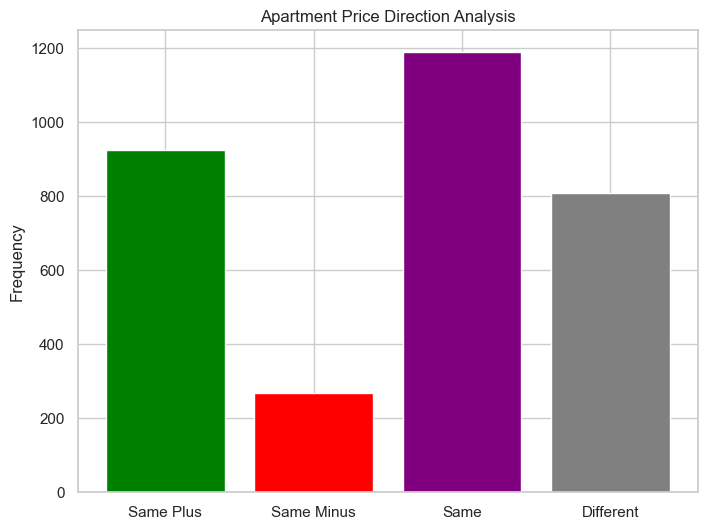

일치율: 0.595691382765531


In [67]:
# 데이터 준비
categories = ['Same Plus', 'Same Minus', 'Same', 'Different']
values = [n_correct_plus, n_correct_minus, n_correct_plus + n_correct_minus, n_wrong]

# 막대 그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['green', 'red', 'purple', 'grey'])
plt.ylabel('Frequency')
plt.title('Apartment Price Direction Analysis')
plt.show()

print(f'일치율: {(n_correct_plus + n_correct_minus) / (n_wrong + n_correct_plus + n_correct_minus)}')

## 3.2 지하철 및 학교 데이터 분석

### 3.2.1 학교 데이터

In [68]:
print(school_df.info())
print(school_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11992 entries, 0 to 11991
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   schoolLevel  11992 non-null  object 
 1   latitude     11992 non-null  float64
 2   longitude    11992 non-null  float64
dtypes: float64(2), object(1)
memory usage: 281.2+ KB
None
schoolLevel    0
latitude       0
longitude      0
dtype: int64


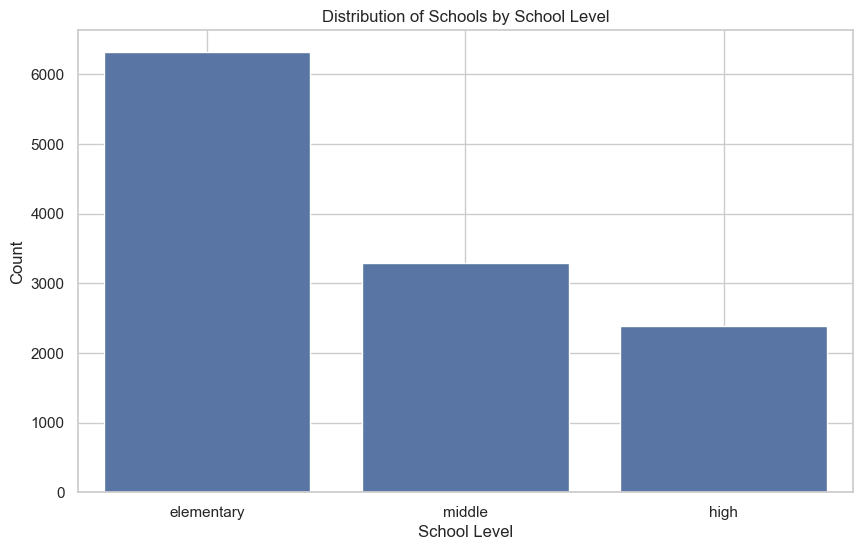

In [69]:
# schoolLevel별 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='schoolLevel', data=school_df)
plt.title('Distribution of Schools by School Level')
plt.xlabel('School Level')
plt.ylabel('Count')
plt.grid(True)
plt.show()

#### 중복값

In [70]:
school_df_same = school_df.groupby(['latitude','longitude']).size().reset_index(name='count')
school_df_same_filtered = school_df_same[school_df_same['count'] != 1]
school_df_same_filtered_sorted = school_df_same_filtered.sort_values(by='count', ascending=False)
school_df_same_filtered_sorted

latitude   longitude  count
8642   37.473960  126.651999      8
1233   35.108185  126.873266      5
10028  37.593949  127.054891      5
10581  37.665252  127.062533      4
10168  37.610946  126.914793      4
...          ...         ...    ...
4151   35.920029  128.815991      2
4120   35.907572  128.624229      2
4113   35.903230  128.620265      2
4060   35.886199  128.421403      2
11422  38.485485  128.433401      2

[505 rows x 3 columns]

In [71]:
school_df_same_filtered_sorted['count'].value_counts()

count
2    461
3     32
4      9
5      2
8      1
Name: count, dtype: int64

- 같은 주소를 가진 초중고등학교가 4개 이상인 경우가 있다.

데이터가 전국의 학교를 포함하기 때문에 모든 아파트에서 거리가 2km 이상인 학교는 제외

In [72]:
# 위도와 경도를 라디안으로 변환 (지구의 곡률을 고려하기 위함)
train_data_radians = np.radians(train_df[['latitude', 'longitude']])
school_data_radians = np.radians(school_df[['latitude', 'longitude']])

# BallTree 생성 (train_data의 위도와 경도를 이용)
tree = BallTree(train_data_radians, metric='haversine')

# 반경 2km(약 0.00314 라디안) 내의 거리 계산
radius = 2 / 6371  # 2km를 라디안으로 변환 (지구 반지름: 6371km)

# 결과를 저장할 리스트
filtered_schools = []

# 각 학교마다 2km 이내 아파트가 있는지 확인
for i in range(len(school_df)):
    school_coords_radians = school_data_radians.iloc[i].values.reshape(1, -1)
    school_coords = (school_df.loc[i, 'latitude'], school_df.loc[i, 'longitude'])

    # 반경 2km 내 아파트 거래 검색
    indices = tree.query_radius(school_coords_radians, r=radius)

    # 2km 이내에 아파트가 있으면 해당 학교를 저장
    if len(indices[0]) > 0:
        filtered_schools.append(school_df.iloc[i])

# 필터링된 학교 데이터프레임 생성
filtered_schools_df = pd.DataFrame(filtered_schools)

# 지도 중심 설정 (필터링된 학교들의 평균 위도, 경도 사용)
map_center = [filtered_schools_df['latitude'].mean(), filtered_schools_df['longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# 마커 색상을 schoolLevel에 따라 다르게 설정
color_dict = {
    'elementary': 'blue',
    'middle': 'green',
    'high': 'red'
}

# 필터링된 schoolLevel별로 지도에 마커 추가
for idx, row in filtered_schools_df.iterrows():
    school_level = row['schoolLevel']
    color = color_dict.get(school_level, 'gray')  # 미지정된 schoolLevel은 회색으로 표시
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"School Level: {school_level}",
        icon=folium.Icon(color=color)
    ).add_to(m)

# 지도 저장 (HTML 파일로 저장)

m.save('filtered_schools_map.html')

동네를 생각해본다면 학교에서 반경 0.6km 이하일 경우, 같은 동네라 생각하고 반경 0.6km 기준으로 시작한다

In [73]:
# 반경 0.6km (약 0.0000942 라디안) 내의 거리 계산
radius_0_6km = 0.6 / 6371  # 0.6km를 라디안으로 변환 (지구 반지름: 6371km)

# 리스트로 각 학교 근처 0.6km 내 아파트 수를 저장
apartments_within_radius = []

# 각 필터링된 학교에 대해 0.6km 이내 아파트 수를 확인
for i in range(len(filtered_schools_df)):
    school_coords_radians = np.radians(filtered_schools_df[['latitude', 'longitude']].iloc[i].values.reshape(1, -1))

    # 반경 0.6km 내 아파트 검색
    indices = tree.query_radius(school_coords_radians, r=radius_0_6km)

    # 해당 학교 근처 0.6km 내 아파트 수를 저장
    num_apartments = len(indices[0])
    apartments_within_radius.append(num_apartments)

# 결과를 새로운 컬럼에 추가
filtered_schools_df['apartments_within_0_6km'] = apartments_within_radius

# 결과 출력
print(filtered_schools_df[['schoolLevel', 'latitude', 'longitude', 'apartments_within_0_6km']])


      schoolLevel   latitude   longitude  apartments_within_0_6km
5          middle  37.486153  127.056121                     2492
7            high  37.395716  126.909033                      981
8            high  37.559989  126.853133                     2572
18           high  37.001940  127.172359                     1407
24     elementary  37.500615  126.924883                      604
...           ...        ...         ...                      ...
11977  elementary  37.477130  127.149414                     3512
11978        high  37.847992  126.881304                        0
11982        high  37.534932  127.227443                     1021
11984  elementary  37.309024  127.089889                     3176
11989  elementary  37.493705  126.900119                     1116

[4060 rows x 4 columns]


In [74]:
filtered_schools_df[filtered_schools_df['apartments_within_0_6km'] == 0]

schoolLevel   latitude   longitude  apartments_within_0_6km
29     elementary  37.116316  127.645391                        0
130        middle  37.126489  127.617090                        0
142        middle  37.303742  127.330793                        0
224    elementary  37.462471  127.130384                        0
267          high  37.583788  126.987473                        0
...           ...        ...         ...                      ...
11673        high  37.758832  127.019645                        0
11802  elementary  37.239018  127.116489                        0
11960        high  37.468636  126.601666                        0
11961  elementary  37.167822  126.984152                        0
11978        high  37.847992  126.881304                        0

[169 rows x 4 columns]

반경 0.6km 로 필터링 한 결과 반경에 아파트 거래가 존재하지 않은 학교도 169개가 발견되었다.

아파트가 없는 학교 시각화

In [75]:

# 필터링된 schools (반경 0.6km 내 아파트가 없는 학교들)
schools_with_no_apartments = filtered_schools_df[filtered_schools_df['apartments_within_0_6km'] == 0]

# 가장 가까운 아파트와 거리를 저장할 리스트
nearest_apartments = []
distances = []

# 각 학교에 대해 가장 가까운 아파트 찾기
for i in range(len(schools_with_no_apartments)):
    school_coords_radians = np.radians(schools_with_no_apartments[['latitude', 'longitude']].iloc[i].values.reshape(1, -1))

    # 가장 가까운 아파트의 인덱스와 거리 찾기 (k=1 이므로 가장 가까운 1개 아파트를 찾음)
    dist, ind = tree.query(school_coords_radians, k=1)

    # 아파트의 인덱스를 이용해 아파트 위치 가져오기
    nearest_apartment_index = ind[0][0]
    nearest_apartment = train_df.iloc[nearest_apartment_index]

    # 가장 가까운 아파트 정보와 거리를 저장
    nearest_apartments.append(nearest_apartment)
    distances.append(dist[0][0])  # 거리 저장 (라디안)

# DataFrame으로 변환
nearest_apartments_df = pd.DataFrame(nearest_apartments)
nearest_apartments_df['distance_km'] = np.array(distances) * 6371  # 거리를 km로 변환

# 지도 중심 설정 (학교들의 평균 위도, 경도 사용)
map_center = [schools_with_no_apartments['latitude'].mean(), schools_with_no_apartments['longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# 학교 마커 추가 (0.6km 내에 아파트가 없는 학교)
for idx, row in schools_with_no_apartments.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"School with No Apartments within 0.6km: {row['schoolLevel']}",
        icon=folium.Icon(color='red')
    ).add_to(m)

# 가장 가까운 아파트 마커 추가
for idx, row in nearest_apartments_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Nearest Apartment, Distance: {row['distance_km']:.2f} km",  # 거리 (km로 변환)
        icon=folium.Icon(color='blue')
    ).add_to(m)

# 지도 저장 (HTML 파일로 저장)
m.save('schools_with_no_apartments_map.html')


## 3.2.2 지하철 데이터

In [76]:
print(subway_df.info())
print(subway_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   700 non-null    float64
 1   longitude  700 non-null    float64
dtypes: float64(2)
memory usage: 11.1 KB
None
latitude     0
longitude    0
dtype: int64


### 환승역 확인

In [77]:
subway_df_same = subway_df.groupby(['latitude','longitude']).size().reset_index(name='count')
subway_df_same_filtered = subway_df_same[subway_df_same['count'] != 1]
subway_df_same_filtered_sorted = subway_df_same_filtered.sort_values(by='count', ascending=False)
subway_df_same_filtered_sorted

latitude   longitude  count
389  37.562434  126.801058      4
331  37.544018  126.951592      4
387  37.561533  127.037732      4
361  37.554648  126.972559      4
431  37.580178  127.046835      4
..         ...         ...    ...
230  37.502162  127.128111      2
221  37.497175  127.027926      2
210  37.493415  127.014080      2
208  37.492970  126.895801      2
542  37.724846  127.046895      2

[99 rows x 3 columns]

In [78]:
subway_df_same_filtered_sorted['count'].value_counts()

count
2    86
3     8
4     5
Name: count, dtype: int64

- 환승역의 경우 2개의 호선이 지나는 것이 86개, 3개가 8개, 4개가 5개 있다.

#### 지하철 시각화

In [79]:
# 위도와 경도에서 고유한 값 추출
unique_locations = train_df[['latitude', 'longitude']].drop_duplicates()

# 지도 중심 설정 (고유 위치들의 평균 위도, 경도를 사용)
map_center = [unique_locations['latitude'].mean(), unique_locations['longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# MarkerCluster 생성
marker_cluster = MarkerCluster().add_to(m)

# 고유한 위도와 경도에 마커 추가 (MarkerCluster로 그룹화)
for idx, row in unique_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(marker_cluster)

# 지하철 데이터 마커 추가 (지하철 위치 700개 추가)
for idx, row in subway_df.iterrows():
    folium.Marker([row['latitude'], row['longitude']],
                  icon=folium.Icon(color='red', icon='train'),
                  popup="Subway").add_to(m)

# 지도 렌더링
display(m)




지하철 역마다 제일 가까운 역까지의 거리를 재서 역간 거리가 먼 곳의 정보를 활용해 보기 위해 필터링

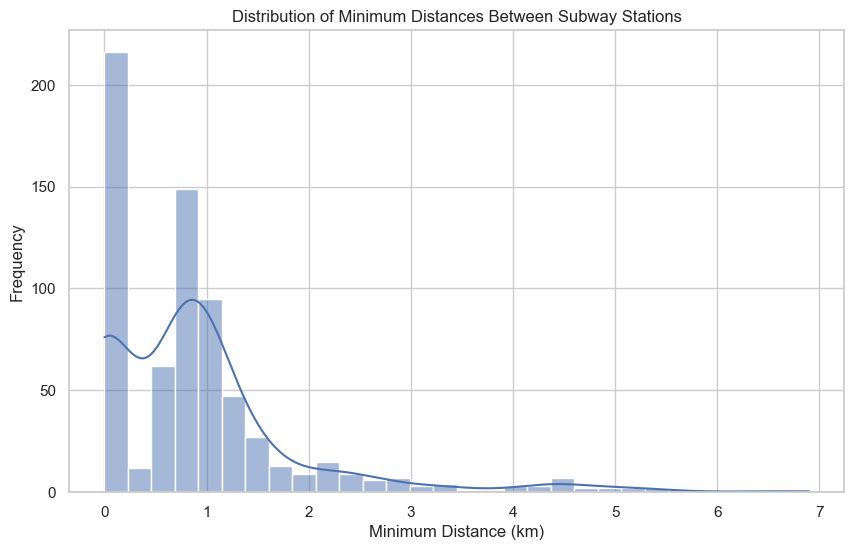

count    700.000000
mean       0.901193
std        1.034896
min        0.000000
25%        0.000000
50%        0.784611
75%        1.104860
max        6.897843
dtype: float64


In [80]:
# 각 지하철역에서 다른 지하철역까지의 최소 거리를 계산
min_distances = []

for i in range(len(subway_df)):
    current_station = (subway_df.loc[i, 'latitude'], subway_df.loc[i, 'longitude'])
    min_distance = float('inf')  # 초기값으로 매우 큰 값을 설정

    for j in range(len(subway_df)):
        if i != j:  # 자신과의 거리는 계산하지 않음
            other_station = (subway_df.loc[j, 'latitude'], subway_df.loc[j, 'longitude'])
            distance = geodesic(current_station, other_station).kilometers
            if distance < min_distance:
                min_distance = distance

    # 최소 거리를 리스트에 추가
    min_distances.append(min_distance)

# 최소 거리 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(min_distances, bins=30, kde=True)
plt.title('Distribution of Minimum Distances Between Subway Stations')
plt.xlabel('Minimum Distance (km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 최소 거리 통계량 확인
min_distance_stats = pd.Series(min_distances).describe()

# 통계량 출력
print(min_distance_stats)

지하철 기준으로 클러스터링을 진행. 반경은 1km로 설정

In [81]:
# KDTree를 사용하기 위해 위도와 경도를 라디안으로 변환 (지구의 곡률을 고려하기 위함)
train_data_radians = np.radians(train_df[['latitude', 'longitude']])
subway_data_radians = np.radians(subway_df[['latitude', 'longitude']])

# BallTree 생성 (train_data의 위도와 경도를 이용)
tree = BallTree(train_data_radians, metric='haversine')

# 반경 1km(약 0.00157 라디안) 내의 거래 수 계산
radius = 1 / 6371  # 1km를 라디안으로 변환 (지구 반지름: 6371km)

# 결과를 저장할 리스트
subway_transaction_counts = []

# 지하철역마다 1km 반경 내의 거래량 계산
for i in range(len(subway_df)):
    subway_station_radians = subway_data_radians.iloc[i].values.reshape(1, -1)

    # 반경 내에 있는 거래의 인덱스 검색
    indices = tree.query_radius(subway_station_radians, r=radius)

    # 해당 반경 내의 거래 수
    transaction_count = len(indices[0])

    # 지하철역별로 1km 반경 내 거래량을 저장
    subway_transaction_counts.append({
        'subway_latitude': subway_df.loc[i, 'latitude'],
        'subway_longitude': subway_df.loc[i, 'longitude'],
        'transaction_count': transaction_count
    })

# 결과를 데이터프레임으로 변환
subway_transaction_df = pd.DataFrame(subway_transaction_counts)


count      700.000000
mean      3829.164286
std       2934.294680
min          0.000000
25%       1340.500000
50%       3445.000000
75%       5511.750000
max      13929.000000
Name: transaction_count, dtype: float64


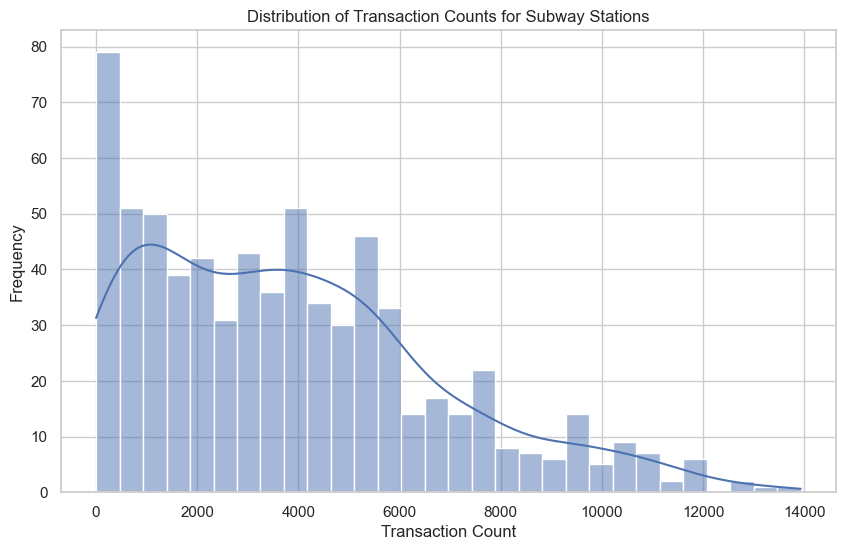

In [82]:
# 거래량에 대한 통계량 계산
transaction_stats = subway_transaction_df['transaction_count'].describe()

# 거래량 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(subway_transaction_df['transaction_count'], bins=30, kde=True)
plt.title('Distribution of Transaction Counts for Subway Stations')
plt.xlabel('Transaction Count')
plt.ylabel('Frequency')
plt.grid(True)

# 통계량 출력
print(transaction_stats)

# 그래프 출력
plt.show()


In [83]:
subway_transaction_df[subway_transaction_df['transaction_count'] == 0].shape

(40, 3)

1km 내에 아파트가 없는 역도 40개가 있다.

아파트와 지하철역까지의 거리가 전세가에 영향을 미치는지 확인하기 위해 각 지하철역마다 1km 반경에 있는 아파트들을 필터링해 상관계수를 계산한다

In [84]:
# 위도와 경도를 라디안으로 변환 (지구의 곡률을 고려하기 위함)
train_data_radians = np.radians(train_df[['latitude', 'longitude']])
subway_data_radians = np.radians(subway_df[['latitude', 'longitude']])

# BallTree 생성 (train_data의 위도와 경도를 이용)
tree = BallTree(train_data_radians, metric='haversine')

# 반경 1km(약 0.00157 라디안) 내의 거리 계산
radius = 1 / 6371  # 1km를 라디안으로 변환 (지구 반지름: 6371km)

# 결과를 저장할 리스트
correlation_data = []

# 지하철역마다 1km 반경 내 전세 거래와 거리의 상관계수 계산
for i in range(len(subway_df)):
    subway_station_radians = subway_data_radians.iloc[i].values.reshape(1, -1)
    subway_station_coords = (subway_df.loc[i, 'latitude'], subway_df.loc[i, 'longitude'])

    # 반경 1km 내 아파트 거래 검색
    indices = tree.query_radius(subway_station_radians, r=radius)

    # 반경 1km 내의 아파트 데이터 추출
    nearby_apartments = train_df.iloc[indices[0]]

    if nearby_apartments.empty:
        continue

    # 지하철역과 아파트 간 거리 계산
    distances = nearby_apartments.apply(
        lambda row: geodesic(subway_station_coords, (row['latitude'], row['longitude'])).kilometers, axis=1
    )

    # 거리와 전세 가격(deposit) 간의 상관계수 계산
    if len(nearby_apartments) > 1:
        correlation = distances.corr(nearby_apartments['deposit'])
    else:
        correlation = np.nan  # 데이터가 적으면 상관계수 계산 불가

    # 상관계수를 리스트에 저장
    correlation_data.append({
        'subway_latitude': subway_df.loc[i, 'latitude'],
        'subway_longitude': subway_df.loc[i, 'longitude'],
        'correlation': correlation
    })

# 결과를 데이터프레임으로 변환
correlation_df = pd.DataFrame(correlation_data)


correlation이 0.4 이상인 역과 -0.4 이하인 역만 필터링 해서 위치를 확인해 일관적인 부분이 있는지 확인한다

In [85]:
# 0.4 이상인 역과 -0.4 이하인 역 필터링
high_positive_corr = correlation_df[correlation_df['correlation'] >= 0.4]
high_negative_corr = correlation_df[correlation_df['correlation'] <= -0.4]

# 지도 중심 설정 (데이터의 평균 위도, 경도 사용)
map_center = [correlation_df['subway_latitude'].mean(), correlation_df['subway_longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# 0.4 이상인 역 마커 추가 (파란색 마커)
for idx, row in high_positive_corr.iterrows():
    folium.Marker(
        location=[row['subway_latitude'], row['subway_longitude']],
        popup=f"Correlation: {row['correlation']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# -0.4 이하인 역 마커 추가 (빨간색 마커)
for idx, row in high_negative_corr.iterrows():
    folium.Marker(
        location=[row['subway_latitude'], row['subway_longitude']],
        popup=f"Correlation: {row['correlation']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# 지도 저장 (HTML 파일로 저장)
m.save('subway_correlation_map.html')


한 지하철역에서 제일 가까운 지하철 역이 1.2km 이상이면 교통이 불편한 지역이라 판단하고, 따라서 역에서 가까울수록 전세가격에 미치는 영향이 상당할 거라고 판단된다.  

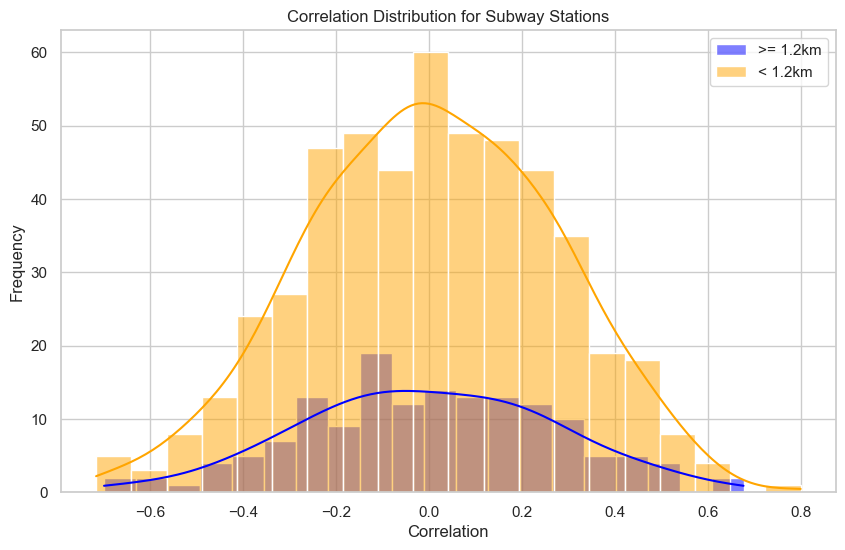

Stations with closest station >= 1.2km:
count    152.000000
mean      -0.001997
std        0.269472
min       -0.698265
25%       -0.195630
50%       -0.007697
75%        0.184687
max        0.675559
Name: correlation, dtype: float64

Stations with closest station < 1.2km:
count    506.000000
mean       0.004656
std        0.264992
min       -0.715355
25%       -0.185456
50%        0.000140
75%        0.197277
max        0.798314
Name: correlation, dtype: float64


In [86]:
# 위도와 경도를 라디안으로 변환 (지구의 곡률을 고려하기 위함)
subway_data_radians = np.radians(subway_df[['latitude', 'longitude']])

# BallTree 생성 (지하철역 간 거리 계산을 위해)
subway_tree = BallTree(subway_data_radians, metric='haversine')

# 결과를 저장할 리스트
distance_groups = []

# 지하철역 간 거리 계산 및 1.2km 이상, 미만으로 그룹화
for i in range(len(correlation_df)):  # 거래가 있는 지하철역만 대상으로 처리
    subway_station_radians = subway_data_radians.iloc[i].values.reshape(1, -1)

    # 가장 가까운 두 지하철역 검색 (자신 포함)
    distances, indices = subway_tree.query(subway_station_radians, k=2)

    # 가장 가까운 다른 지하철역까지의 거리 계산
    closest_distance = distances[0][1] * 6371  # 라디안 -> km 변환

    # 1.2km 이상인 경우와 미만인 경우를 나누어 저장
    if closest_distance >= 1.2:
        distance_groups.append('>= 1.2km')
    else:
        distance_groups.append('< 1.2km')

# 거래가 있는 지하철역에 대해서만 그룹화된 데이터를 correlation_df에 추가
correlation_df['distance_group'] = distance_groups

# 1.2km 이상과 미만 그룹의 상관관계 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(correlation_df[correlation_df['distance_group'] == '>= 1.2km']['correlation'], color='blue', label='>= 1.2km', kde=True, bins=20)
sns.histplot(correlation_df[correlation_df['distance_group'] == '< 1.2km']['correlation'], color='orange', label='< 1.2km', kde=True, bins=20)
plt.title('Correlation Distribution for Subway Stations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# 각 그룹의 통계량 출력
print("Stations with closest station >= 1.2km:")
print(correlation_df[correlation_df['distance_group'] == '>= 1.2km']['correlation'].describe())

print("\nStations with closest station < 1.2km:")
print(correlation_df[correlation_df['distance_group'] == '< 1.2km']['correlation'].describe())


확인 결과, 1.2 km 이상인 곳에서 correlation이 0에 근사하는 비율이 상당히 낮아지긴 했으나 영향에 대한 정확한 평가가 어려움을 알 수 있다. 특히나 정규분포를 형성하고 있어 다른 변인 요소를 제외했는지 확인할 필요가 있다. 추측으로는 건물의 나이, 건물의 면적 등이 추가적으로 고려되서 들어가야 한다

# 4. 금리와 전세가 분석

In [87]:
print(interest_df.info())
print(interest_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_month     66 non-null     int64  
 1   interest_rate  66 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB
None
year_month       0
interest_rate    0
dtype: int64


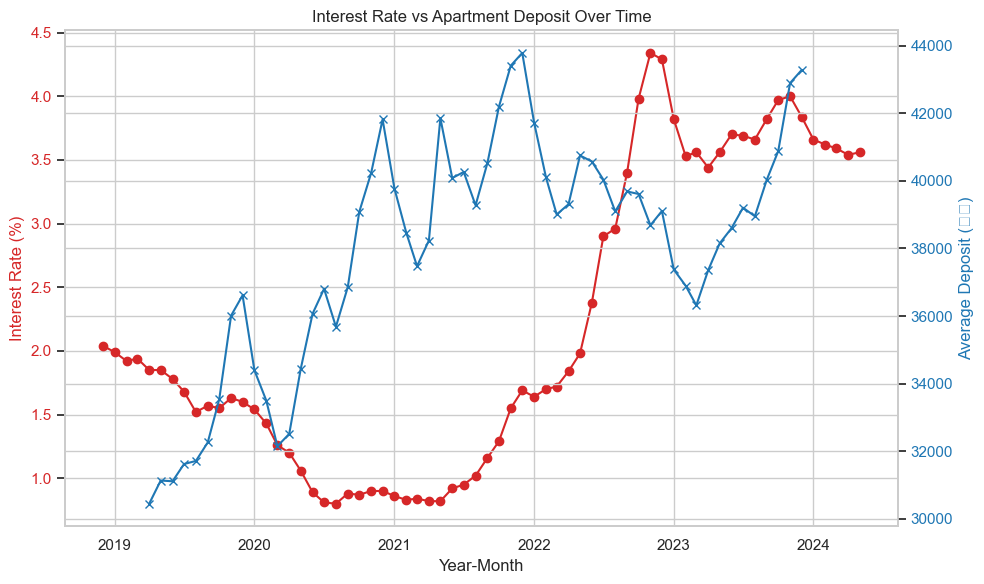

In [88]:

train_data = train_df.copy()
# 1. 금리 데이터 전처리
# 금리 데이터를 datetime 형식으로 변환
interest_df['year_month'] = pd.to_datetime(interest_df['year_month'], format='%Y%m')

# 2. 전세 가격 데이터 전처리
# 계약 연도 및 계약 월을 기반으로 연월 계산
train_data['contract_year_month'] = train_data['contract_year_month'].astype(str)
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')

# 연도별 평균 전세 가격 계산
year_month_deposit = train_data.groupby('contract_year_month')['deposit'].mean().reset_index()

# 3. 금리와 전세 가격 변화를 함께 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 축: 금리
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Interest Rate (%)', color='tab:red')
ax1.plot(interest_df['year_month'], interest_df['interest_rate'], color='tab:red', marker='o', linestyle='-', label='Interest Rate')
ax1.tick_params(axis='y', labelcolor='tab:red')

# 두 번째 축: 전세 가격
ax2 = ax1.twinx()  # 두 번째 y축 생성
ax2.set_ylabel('Average Deposit (만원)', color='tab:blue')
ax2.plot(year_month_deposit['contract_year_month'], year_month_deposit['deposit'], color='tab:blue', marker='x', linestyle='-', label='Average Deposit')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# 제목 및 기타 설정
plt.title('Interest Rate vs Apartment Deposit Over Time')
fig.tight_layout()  # 레이아웃 조정
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


- 그래프는 금리 변화와 평균 아파트 전세 가격을 비교한 것이다.
- 2020~2021년에 금리가 급격이 낮아지면서 1.0%이하로 내려간다. 이 기간 동안 전세 가격은 급격하게 상승하는 추세를 보인다.
- 2022년은 금리가 급격하게 상승하면서 전세 가격의 상승폭이 둔화되거나 하락하는 현상이 관찰된다.
- 2023년은 금리가 어느 정도 안정되면서 전세 가격은 완만한 상승세를 유지하고 있는 것을 볼 수 있다. 
- 2024년에는 금리가 3.5% 수준에서 유지되고 있으며 이로 인해, 전세 가격의 급격한 상승은 나타나지 않고 소폭 상승할 가능성이 있다고 보여진다.